# Smart Plan Data mining (No-show)

## Outline
- [1 - Business Understanding](#1)
- [2 - Data Understanding](#2)
  - [2.1 - Initial Data Collection](#2.1)
  - [2.2 - Data Description](#2.2)
  - [2.3 - Data Exploration](#2.3)
- [3 - Data Preparation](#3)
  - [3.1 - Data Cleaning](#3.1)
    - [3.1.1 - Missing Values](#3.1.1)
    - [3.1.2 - Outliers](#3.1.2)
  - [3.2 - Data Transformation](#3.2)
    - [3.2.1 - Feature engeenering](#3.2.1)
    - [3.2.2 - Data Standardization](#3.2.2)
- [4 - Modeling and Evaluation ](#4)
  - [4.1 - Random Forest](#4.1)
      - [4.1.1 - Training model](#4.1.1)
      - [4.1.2 - Evaluation ](#4.1.2)
  - [4.2 - Neural Networks](#4.2)    
      - [4.2.1 - Training model](#4.2.1)
      - [4.2.2 - Evaluation ](#4.2.2)
  - [4.3 - KNN ](#4.3)



<a name="1"></a>
## 1 - Business Understanding

<a name="1.1"></a>
## 1.1 Business Objectives
- Minimize the average waiting time and the average idle time in outpatient clinic

## 1.2 Current Situation
- Discussion of current scheduling procedures (See literature review).

## 1.3 Data Mining Goals
-  Predict the proability of no-show

<a name="2"></a>
## 2 - Data Understanding

<a name="2.1"></a>
## 2.1 - Initial Data Collection

In [1]:
#Load our local fonctions
from utils_ns import *
# load librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Genera setting
path_data = "data/consult_waits_2024_03_25.csv"

In the following code block, we are loading data using `pandas.read_csv` with a predefined list of columns and specified data types for each column. This approach helps optimize memory usage by ensuring that each column is stored in the most memory-efficient format suitable for its data type.

- **Columns to Load**: We specify the columns to be loaded to avoid unnecessary memory usage by excluding irrelevant data. The `dto` variable is excluded because it's the sum of `dta` and `dtc`. Additionally, `year` and `month` were not loaded as they are sub-parts of the `activitydatetime` column. 
- **Data Types**: Specifying data types explicitly (`dtype`) helps in several ways:
- **Error Handling**: We include error handling during the load process to catch issues that might occur if the data does not conform to the expected format or if there are issues reading the file. This can help in debugging and ensuring data quality.

![Variables Description](./images/variables_description.PNG)
*Variables Description of raw data*


In [3]:
# List of column to load
cols_to_use = ['patientsid', 'activitydatetime', 'sta3n', 'stopcode',
               'dta', 'dts', 'dtc', 'non_va', 'zip', 'state', 'disp', 'AdministrativeFlag']

data_types = {
    'patientsid': 'uint32',
    'sta3n': 'category',
    'stopcode': 'category',
    'dta': 'float32',
    'dts': 'float32',
    'dtc': 'float32',
    'non_va': 'category',
    'zip': 'category',
    'state': 'category',
    'disp': 'category',
    'AdministrativeFlag': 'category'
}
# Pour capturer les éventuelles erreurs de chargement et les traiter
try:
    data = pd.read_csv(path_data, dtype=data_types, usecols=cols_to_use)
except Exception as e:
    print("Une erreur est survenue lors de la lecture du fichier CSV:", e)

<a name="2.2"></a>
### 2.2 - Data description

In [4]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51874107 entries, 0 to 51874106
Data columns (total 12 columns):
 #   Column              Dtype   
---  ------              -----   
 0   patientsid          uint32  
 1   activitydatetime    object  
 2   sta3n               category
 3   stopcode            category
 4   dta                 float32 
 5   dts                 float32 
 6   dtc                 float32 
 7   non_va              category
 8   zip                 category
 9   state               category
 10  disp                category
 11  AdministrativeFlag  category
dtypes: category(7), float32(3), object(1), uint32(1)
memory usage: 4.9 GB


In [6]:
data.head()

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,dtc,non_va,zip,state,disp,AdministrativeFlag
0,9204541,2023-06-15 14:43:56,573,354,5.0,3.0,0.0,1,315,GEORGIA,COMPLETE/UPDATE,Y
1,9204541,2017-02-01 10:20:10,573,403,0.0,30.0,64.0,0,315,GEORGIA,COMPLETE/UPDATE,NaN
2,9204541,2021-11-03 09:32:28,573,407,2.0,54.0,48.0,1,315,GEORGIA,COMPLETE/UPDATE,Y
3,9204541,2015-03-26 14:30:45,573,408,1.0,134.0,149.0,0,315,GEORGIA,COMPLETE/UPDATE,NaN
4,9204541,2019-02-08 12:41:00,573,409,0.0,28.0,44.0,0,315,GEORGIA,COMPLETE/UPDATE,NaN


*Numeric Data Summary*:

In [7]:
data.describe()

,patientsid,dta,dts,dtc
count,5.187411e+07,5.187411e+07,5.187411e+07,5.187411e+07
mean,4.984383e+08,2.999573e+00,1.702318e+01,3.565650e+01
std,5.770953e+08,1.062987e+01,2.838260e+01,3.486901e+01
min,1.306000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.353260e+07,0.000000e+00,1.000000e+00,1.300000e+01
50%,2.602300e+07,1.000000e+00,6.000000e+00,2.600000e+01
75%,1.007936e+09,2.000000e+00,2.000000e+01,4.600000e+01
max,1.605574e+09,3.650000e+02,1.367000e+03,3.650000e+02


*Categorical Data Summary*:

In [ ]:
categorical = data.dtypes[data.dtypes == "category"].index
print(categorical)
data[categorical].describe()

Index(['sta3n', 'stopcode', 'non_va', 'zip', 'state', 'disp',
       'AdministrativeFlag'],
      dtype='object')


,sta3n,stopcode,non_va,zip,state,disp,AdministrativeFlag
count,51874107,51874107,51874107,51873257,51874107,51874107,20182672
unique,130,365,2,921,67,4,3
top,589,205,0,782,FLORIDA,COMPLETE/UPDATE,Y
freq,1066491,2870638,36757317,520511,4708517,49443083,16487037


In [ ]:
data['disp'].unique()

['COMPLETE/UPDATE', 'DISCONTINUED', 'CANCELLED', 'EU']
Categories (4, object): ['CANCELLED', 'COMPLETE/UPDATE', 'DISCONTINUED', 'EU']

<a name="2.3"></a>
### 2.3 - Data Exploration

Explore the data to uncover patterns, relationships, and potential anomalies. This step includes visualizing distributions of numeric and categorical data and examining relationships between variables.

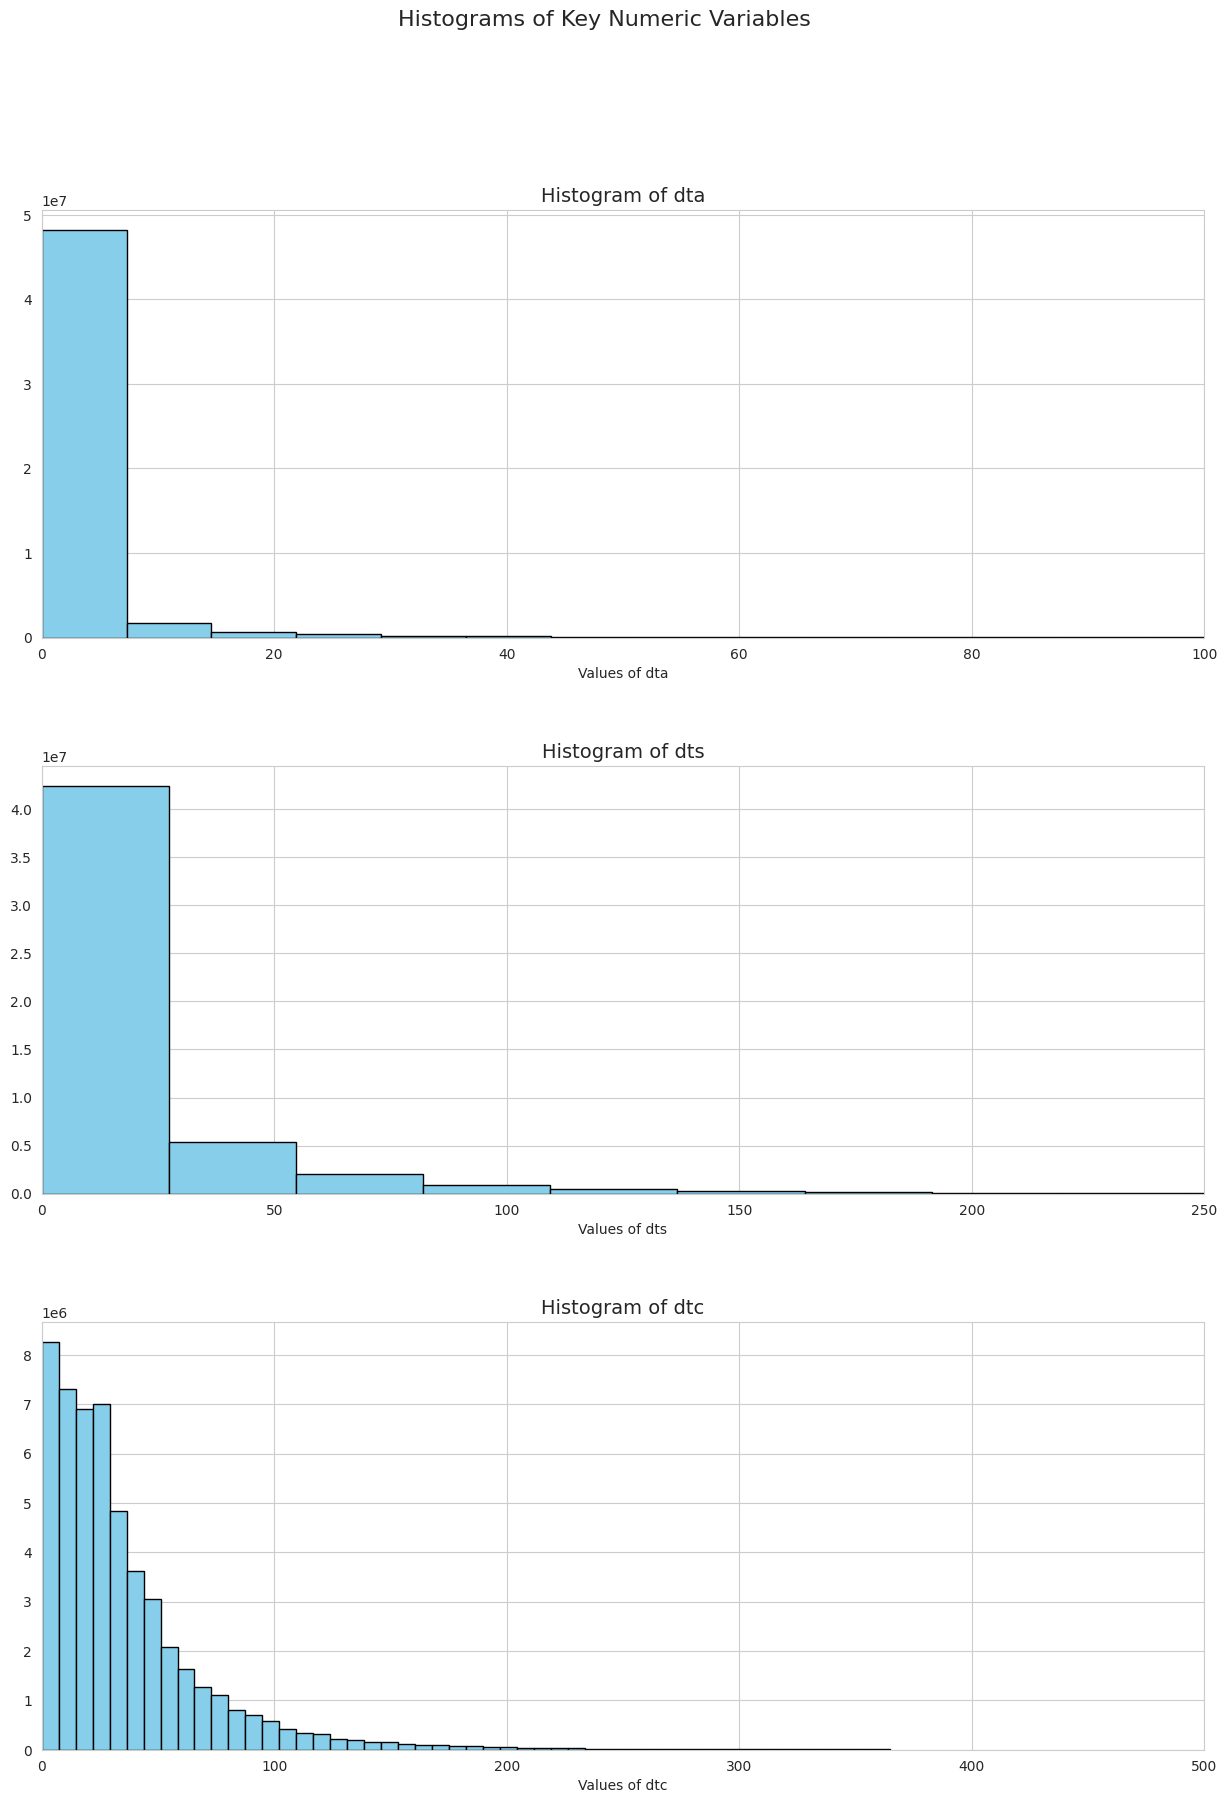

In [ ]:
plot_histograms_numeric(data)

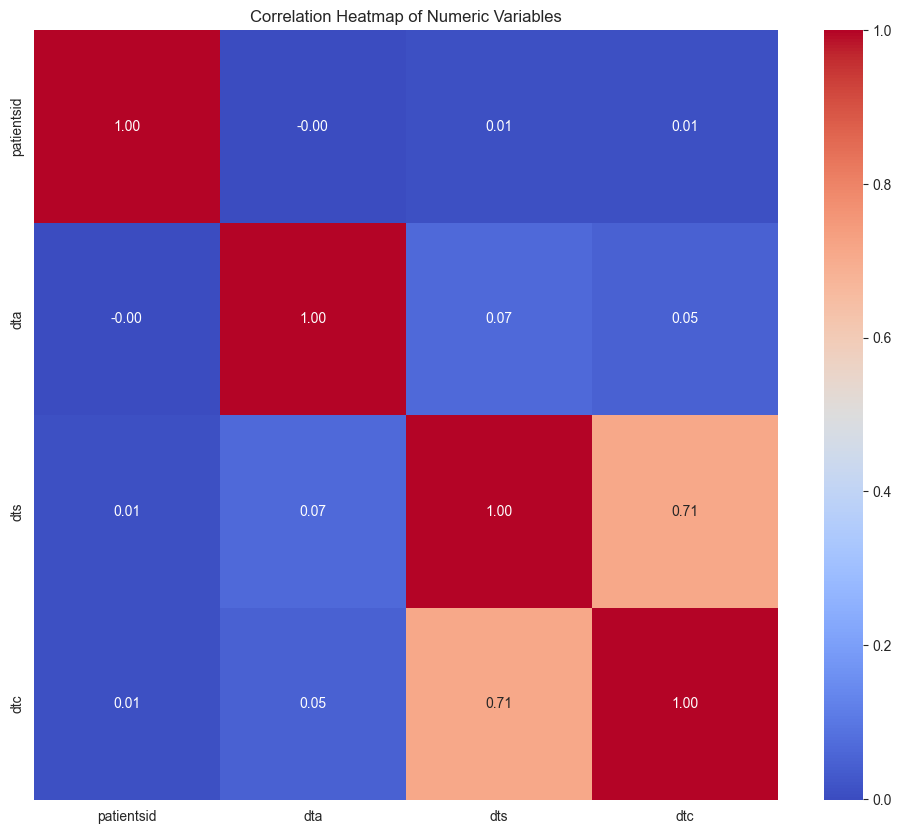

In [ ]:
## Correlation Heatmap of Numeric Variables
plt.figure(figsize=(12, 10))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Variables')
#plt.show()

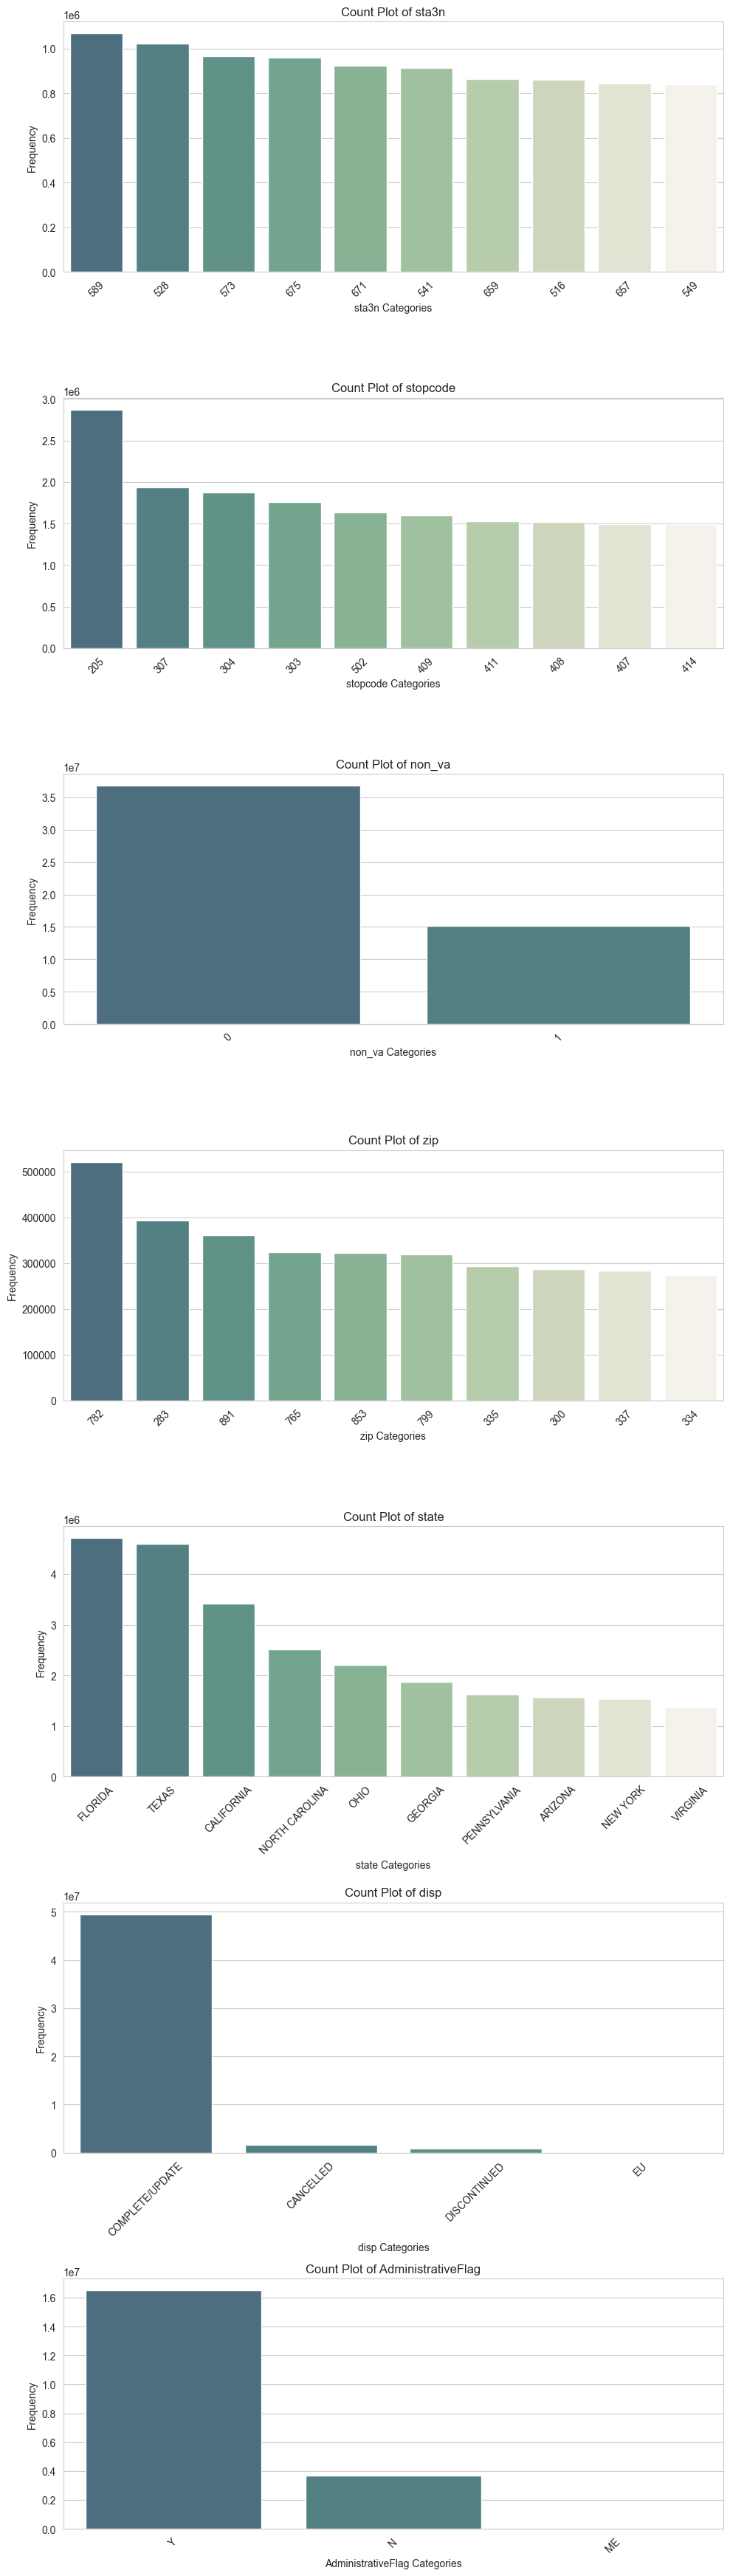

In [5]:
plot_top_category_counts(data)

Corélation entre dts et dtc qui corobore bien notre choix de résumer ces deux information en une seule, le temps de service

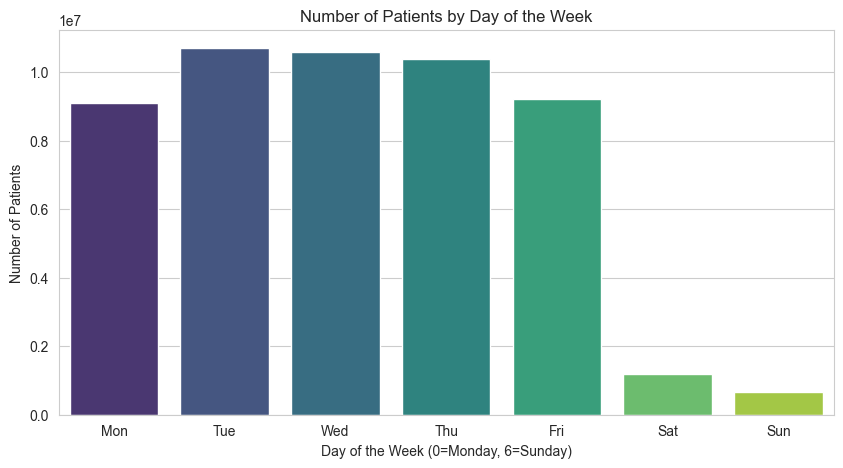

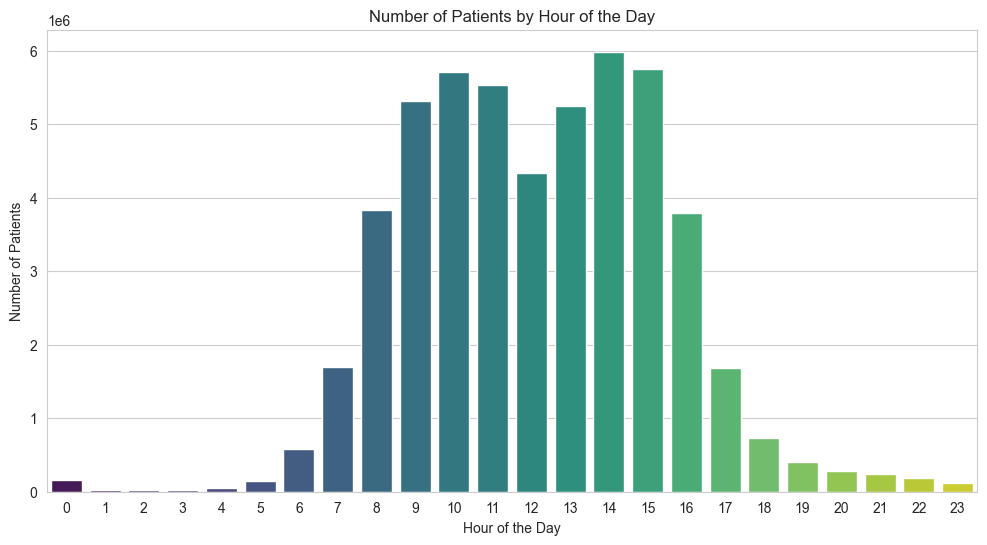

In [ ]:
analyze_working_patterns(data)

<a name="3"></a>
## 3 - Data Preparation
<a name="3.1"></a>
### 3.1 - Data Cleaning

<a name="3.1.1"></a>
3.1.1 - Missing Values

Missing Values Count Per Column:
patientsid                   0
activitydatetime             0
sta3n                        0
stopcode                     0
dta                          0
dts                          0
dtc                          0
non_va                       0
zip                        850
state                      628
disp                         0
AdministrativeFlag    31691435
dtype: int64

Missing Values Percentage Per Column:
zip                    0.001639
state                  0.001211
AdministrativeFlag    61.092975
dtype: float64


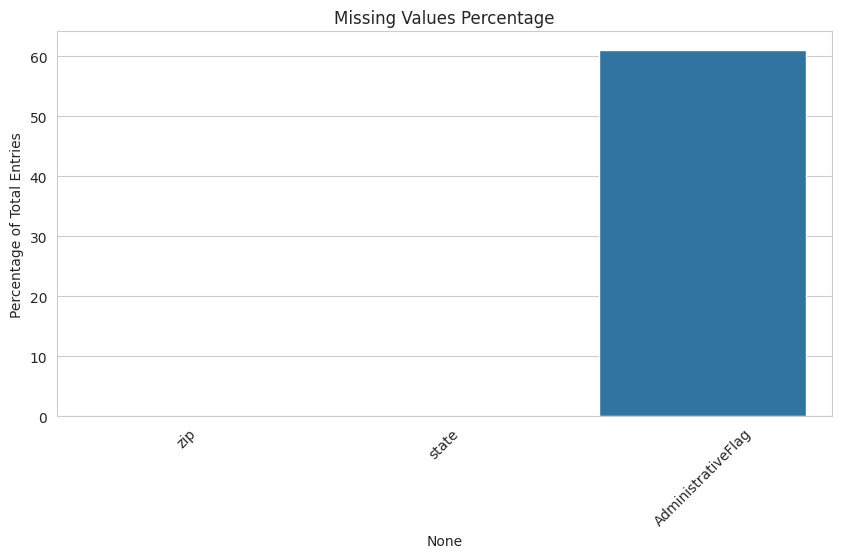

In [ ]:
display_missing_values(data)

In [ ]:
data[data['zip'].isnull()].head()

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,dtc,non_va,zip,state,disp,AdministrativeFlag
132087,24261,2015-06-15 11:54:58,358,423,0.0,0.0,0.0,0,NaN,*Missing*,COMPLETE/UPDATE,Y
132105,27765,2015-02-20 16:43:23,358,423,0.0,0.0,0.0,0,NaN,*Missing*,COMPLETE/UPDATE,Y
375782,1602406208,2022-09-16 21:09:17,663,323,1.0,13.0,72.0,1,NaN,*Missing*,COMPLETE/UPDATE,Y
426598,801540320,2016-04-04 13:54:34,691,104,7.0,0.0,7.0,0,NaN,*Missing*,COMPLETE/UPDATE,N
962087,800924574,2016-05-15 09:56:05,691,104,0.0,1.0,34.0,0,NaN,CALIFORNIA,COMPLETE/UPDATE,N


In [4]:
# Filter rows where 'AdministrativeFlag' is null and display the last 10 rows
data[data['AdministrativeFlag'].isnull()].tail(5)

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,dtc,non_va,zip,state,disp,AdministrativeFlag
51874089,7941828,2023-05-15 09:15:35,557,414,35.0,0.0,7.0,0,312,GEORGIA,CANCELLED,NaN
51874095,7949492,2022-05-16 10:58:36,557,303,0.0,10.0,15.0,0,310,GEORGIA,COMPLETE/UPDATE,NaN
51874096,7949492,2014-10-01 13:14:59,557,307,3.0,35.0,44.0,0,310,GEORGIA,COMPLETE/UPDATE,NaN
51874097,7949492,2022-01-25 12:43:47,557,338,3.0,65.0,65.0,0,310,GEORGIA,COMPLETE/UPDATE,NaN
51874102,7949492,2022-09-28 11:07:20,557,414,0.0,12.0,21.0,0,310,GEORGIA,COMPLETE/UPDATE,NaN


Given the high volume of missing data and its MAR (Missing at Random) nature, and we assume AdministrativeFlag is not critical to analysis, considering its removal could streamline the dataset and focus efforts on more reliable variables.
- *Missing value prepocessing*

In [4]:
data.drop('AdministrativeFlag', axis=1, inplace=True)

In [5]:
# Identifier les indices des lignes où 'zip' est NaN ou 'state' est '*Missing*'
missing_zip_index = data[data['zip'].isnull()].index
missing_state_index = data[data['state'] == '*Missing*'].index

# Combinez les indices dans un seul ensemble pour assurer l'unicité
all_missing_indices = missing_zip_index.union(missing_state_index)

# Supprimer les lignes avec des indices combinés en une seule opération
data.drop(index=all_missing_indices, inplace=True)

In [6]:
print(data.shape)

(51873257, 11)


<a name="3.1.2"></a>
3.1.2 - Outliers

Outliers (IQR) Count Per Numeric Column:
{'patientsid': 0, 'dta': 5461500, 'dts': 4798986, 'dtc': 3220423}


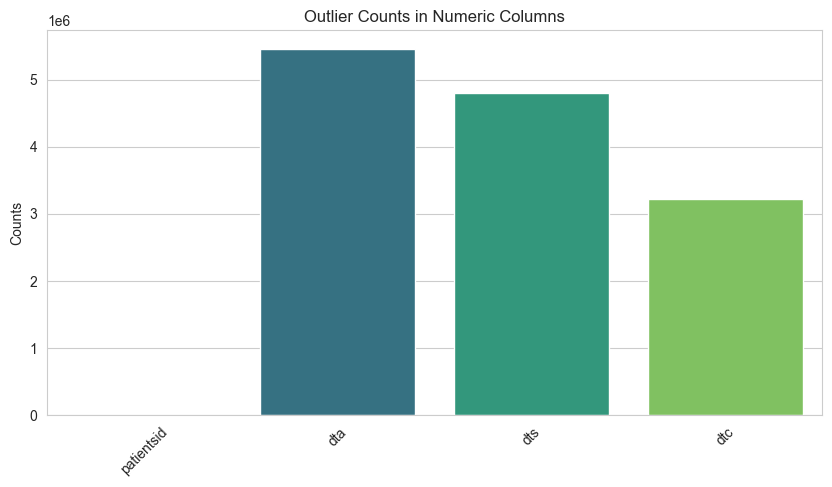

In [7]:
visualize_outliers(data)

Traitement des outliers

In [8]:
# Find and display rows where 'dts' is greater than 'dtc'
len_out_dtc = len(data[data['dts'] > data['dtc']])
print("Number of Rows where 'dts' is greater than 'dtc':", len_out_dtc)

Number of Rows where 'dts' is greater than 'dtc': 2880010


In [9]:
# Filter the data to remove rows where 'dts' is greater than 'dtc'
data = data[data['dts'] < data['dtc']]

# Display new data shape after removing erroneous entries
print("New data shape after outlier removal:", data.shape)


New data shape after outlier removal: (45723552, 11)


In [10]:
remove_outliers_from_dataframe(data)

Data shape after outlier removal: (36688080, 11)
Total outliers removed: 9035472


9035472

#### Outlier Detection in Categorical Variables
For categorical variables, We assume that any anomalies or irregular entries were controlled during data entry, often through enforced choices like dropdown menus or checklists.


<a name="3.1.3"></a>
3.1.3 - Duplicated Values 

In [12]:
initial_count = len(data)
data.drop_duplicates(inplace=True)
duplicates_removed = initial_count - len(data)
print(f'Number of deleted duplicates: {duplicates_removed}')

Number of deleted duplicates: 134


In [13]:
print(data.shape)

(36687946, 11)


<a name="3.2"></a>
3.2 - Data Transformation

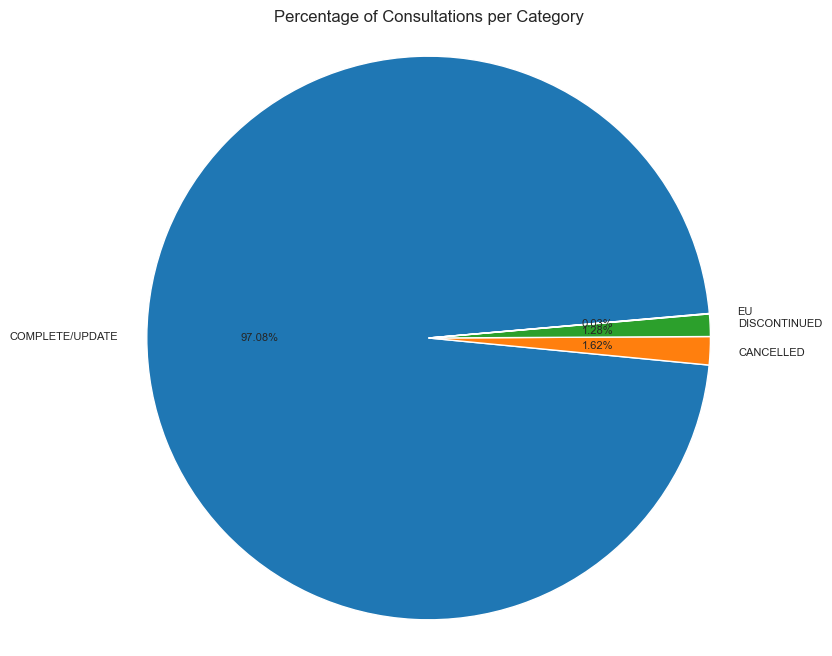

In [36]:
# Plotting the number of consultations per category
plot_consultation_counts(data)

###### Assumptions about final Dispositions (`disp`)

In our analysis, we made specific assumptions about the meanings of different disposition statuses in our data:

- **Canceled**: We have assumed that consultations with a final disposition of "Canceled" correspond to no-shows, where patients did not attend their scheduled appointments.
  
- **Completed/Update**: Consultations labeled as "Completed/Update" are considered successful, where everything proceeded as planned without any issues.

We have **not included** consultations with dispositions labeled as "Discontinued" and "EU" in our analysis. These categories were excluded to focus on clear-cut outcomes—either completed consultations or no-shows.

This approach simplifies our analysis by focusing only on definitive outcomes and allows for a more straightforward interpretation of our data.


In [15]:
# Filter to keep only 'COMPLETE/UPDATE' and 'CANCELLED'
data = data[data['disp'].isin(['COMPLETE/UPDATE', 'CANCELLED'])]

# Map 'COMPLETE/UPDATE' to 1 and 'CANCELLED' to 0
data['disp'] = data['disp'].map({'COMPLETE/UPDATE': 1, 'CANCELLED': 0})

In [16]:
# Convertir la colonne 'disp' en type catégoriel
data['disp'] = data['disp'].astype('category')

<a name="3.2.1"></a>
3.2.1 - Feature engeneering 

In [17]:
# Add the new column 'ts' by subtracting 'dts' from 'dtc'
data['ts'] = data['dtc'] - data['dts']
# drop the corresponding columns
data.drop(['dtc', 'dts'], axis=1, inplace=True)

print("Data after dropping 'dtc' and 'dts':")

data.head()

Data after dropping 'dtc' and 'dts':


,patientsid,activitydatetime,sta3n,stopcode,dta,non_va,zip,state,disp,ts
1,9204541,2017-02-01 10:20:10,573,403,0.0,0,315,GEORGIA,1.0,34.0
4,9204541,2019-02-08 12:41:00,573,409,0.0,0,315,GEORGIA,1.0,16.0
6,9204541,2020-06-29 12:56:56,573,502,4.0,1,315,GEORGIA,1.0,8.0
7,9204546,2017-10-11 10:42:46,573,142,0.0,0,461,INDIANA,1.0,64.0
10,9204549,2022-11-15 10:08:28,573,205,0.0,0,322,FLORIDA,1.0,50.0


In [18]:
remove_outliers_from_column(data, "ts")

Data shape after outlier removal in column ts: (34605775, 10)
Total outliers removed from column ts: 1603290


1603290

In [19]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34605775 entries, 1 to 51874102
Data columns (total 10 columns):
 #   Column            Dtype   
---  ------            -----   
 0   patientsid        uint32  
 1   activitydatetime  object  
 2   sta3n             category
 3   stopcode          category
 4   dta               float32 
 5   non_va            category
 6   zip               category
 7   state             category
 8   disp              category
 9   ts                float32 
dtypes: category(6), float32(2), object(1), uint32(1)
memory usage: 3.4 GB


In [20]:
# Convert the datetime column to datetime type if not already
data['activitydatetime'] = pd.to_datetime(data['activitydatetime'])
# Add temporal features
data['day_of_week'] = data['activitydatetime'].dt.dayofweek
data['day_of_month'] = data['activitydatetime'].dt.day
data['month'] = data['activitydatetime'].dt.month
data['hour'] = data['activitydatetime'].dt.hour
data.drop('activitydatetime', axis=1, inplace=True)

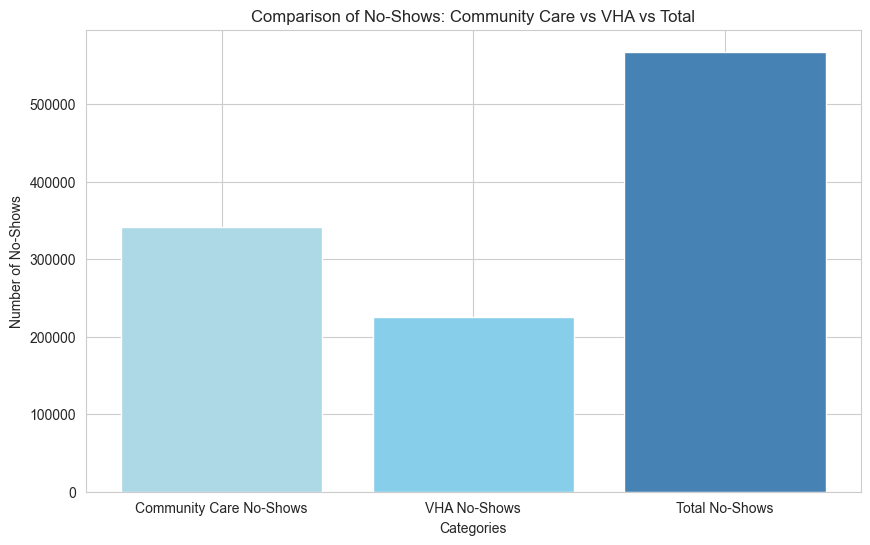

In [44]:
plot_no_show_comparison(data)

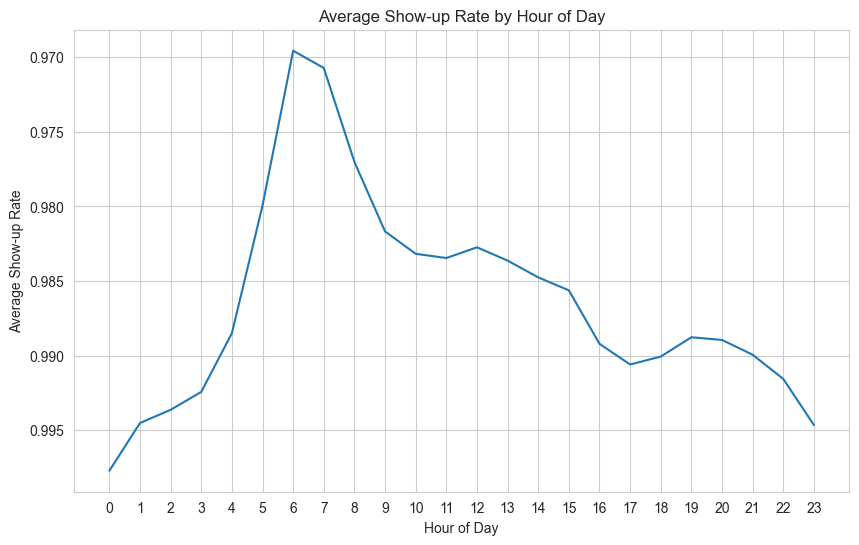

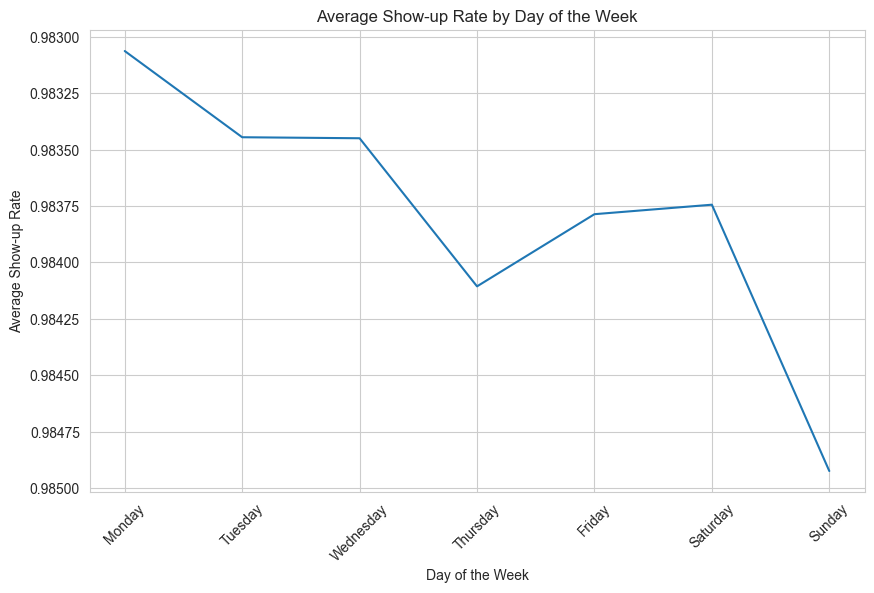

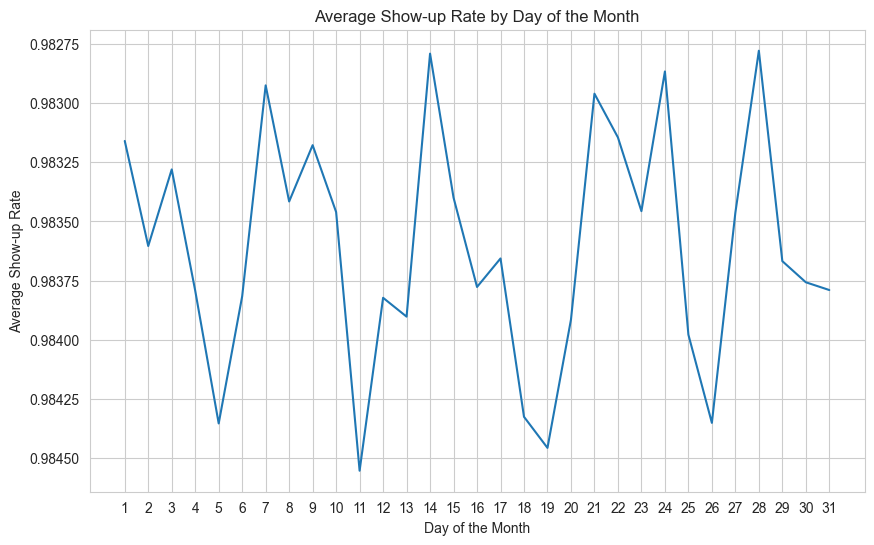

In [22]:
plot_patient_flow(data)

In [17]:
data = encode_categorical_columns(data)

In [18]:
data.head(3)

,patientsid,sta3n,stopcode,dta,zip,state,disp,ts,day_of_week,day_of_month,month,hour,non_va_0,non_va_1
0,9204541,54,181,0.0,299,15,1.0,34.0,2,1,2,10,1.0,0.0
1,9204541,54,187,0.0,299,15,1.0,16.0,4,8,2,12,1.0,0.0
2,9204541,54,244,4.0,299,15,1.0,8.0,0,29,6,12,0.0,1.0


On standardise uniquement le modèle ANN, mais ce n'ai pas necessaire pour le modèle Random Forest.

<a name="3.2.2"></a>
3.2.2 - Data Standardization

In [44]:
exclude_column='patientsid'
# Identify numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

# Remove the excluded column name from the list of columns to be standardized
if exclude_column in numeric_cols :
    numeric_cols.remove(exclude_column)
#standardization only on the selected numeric columns
#scaler = StandardScaler()
#data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [55]:
# Convertir la colonne 'disp' en type catégoriel
data['disp'] = data['disp'].astype('float')

In [25]:
target = "disp"
# Separate features and target
X = data.drop(columns=[target])
y = data[target]
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


<a name="4"></a>
## 4 - Modeling

<a name="4.1"></a>
## 4.1 - Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

<a name="4.1.1"></a>
### 4.1.1 - Training model

In [28]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# we save model 
#dump(model, 'no_show_random_forest_model.joblib')
#print("Modèle enregistré avec succès.")

Modèle enregistré avec succès.


In [22]:
# Chargement du modèle
model = load('no_show_random_forest_model.joblib')

In [28]:
# Prédictions de classes et de probabilités
y_pred = model.predict(X_test)
#proba for positive class
y_prob = model.predict_proba(X_test)[:, 1] 

<a name="4.1.2"></a>
### 4.1.2 - Model Evaluation Overview

We assess our model using key metrics and visualizations to understand its performance across various aspects:

### Metrics
- **Precision**: Measures the accuracy of positive predictions :
  - $$\text{Precision} = \frac{TP}{TP + FP}$$
- **Recall**: Measures the ability to identify all relevant instances (sensitivity):
  - $$\text{Recall} = \frac{TP}{TP + FN}$$
- **Accuracy**: Measures the proportion of true results (both true positives and true negatives):
  - $$\text{Accuracy} = \frac{TP + TN}{TP + FP + TN + FN}$$
- **F1 Score**: Harmonic mean of Precision and Recall, balancing the two metrics :
  - $$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \times TP}{2 \times TP + FP + FN}$$


### Visualizations
- **AUC - ROC Curve**: Demonstrates the model's ability to differentiate between classes.
- **Learning Curve**: Shows how the model's performance improves with more training data.

In [37]:
metrics = evaluate_model(model, X_test, y_test, y_pred, y_prob)

Accuracy(%): 98.47
ROC-AUC: 0.81
Precision(%): 98.49
Recall(%): 99.97
F1 Score: 0.99


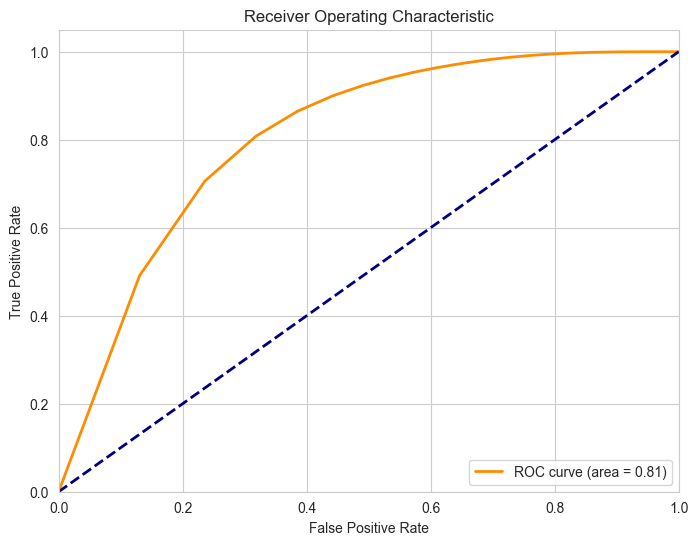

In [46]:
# Calculating probabilities for the positive class
y_scores = model.predict_proba(X_test)[:, 1]
auc_value = plot_auc_curve(model, X_test, y_test, y_scores)

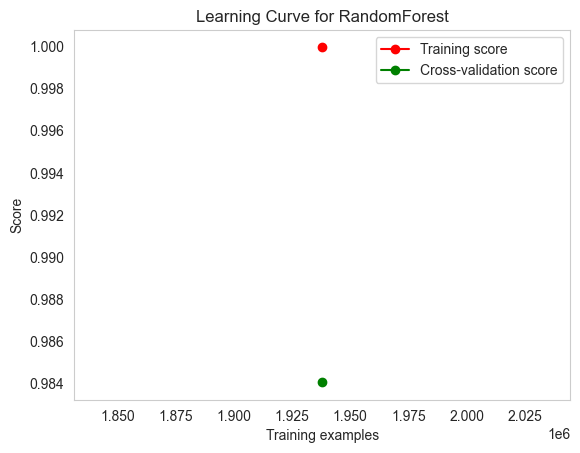

In [35]:
# Générer le learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring="accuracy")
# plot learning curve
plot = plot_learning_curve(train_sizes, train_scores, test_scores, "Learning Curve for RandomForest")
plot.show()

<a name="4.2"></a>
## 4.2 - ANN

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [71]:
# Construction du modèle, MLP
model = tf.keras.Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle, 
model.compile(optimizer='adam',
              loss='weighted binary crossentropy', # weighted étant donné que les deux classes sont loin d'être proporstionnelle
              metrics=['accuracy'])

# Entraînement du modèle
model.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
605602/605602 ━━━━━━━━━━━━━━━━━━━━ 1221s 2ms/step - accuracy: 0.9813 - loss: 13061.5801 - val_accuracy: 0.9836 - val_loss: 0.0837
Epoch 2/50
605602/605602 ━━━━━━━━━━━━━━━━━━━━ 1227s 2ms/step - accuracy: 0.9836 - loss: 0.0839 - val_accuracy: 0.9836 - val_loss: 0.0837
Epoch 3/50
605602/605602 ━━━━━━━━━━━━━━━━━━━━ 1117s 2ms/step - accuracy: 0.9837 - loss: 0.0837 - val_accuracy: 0.9836 - val_loss: 0.0837
Epoch 4/50
605602/605602 ━━━━━━━━━━━━━━━━━━━━ 1125s 2ms/step - accuracy: 0.9836 - loss: 0.0839 - val_accuracy: 0.9836 - val_loss: 0.0837
Epoch 5/50
605602/605602 ━━━━━━━━━━━━━━━━━━━━ 1126s 2ms/step - accuracy: 0.9836 - loss: 0.0837 - val_accuracy: 0.9836 - val_loss: 0.0837
Epoch 6/50
605602/605602 ━━━━━━━━━━━━━━━━━━━━ 1122s 2ms/step - accuracy: 0.9836 - loss: 0.0838 - val_accuracy: 0.9836 - val_loss: 0.0835
Epoch 7/50
605602/605602 ━━━━━━━━━━━━━━━━━━━━ 1136s 2ms/step - accuracy: 0.9836 - loss: 0.0837 - val_accuracy: 0.9836 - val_loss: 0.0837
Epoch 8/50
605602/605602 ━━━━━━━━━━━━